In [2]:
import csky as cy
import numpy as np
import socket, getpass, sys, os
import config as cg
import trials
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

cy.plotting.mrichman_mpl()

Running as User: ssclafani on Hostname: cobalt07.icecube.wisc.edu


/mnt/ceph1-npx/user/ssclafani/software/external/csky/csky/plotting.py:92: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  r'\SetSymbolFont{operators}   {sans}{OT1}{cmss} {m}{n}'


In [3]:
hostname = socket.gethostname()
username = getpass.getuser()
print('Running as User: {} on Hostname: {}'.format(username, hostname))
job_base = 'gp_fit_bf'
#job_base = 'systematics_full'
if 'condor00' in hostname or 'cobol' in hostname or 'gpu' in hostname:
    repo = cy.selections.Repository(
        local_root='/data/i3store/users/ssclafani/data/analyses'.format(username))
    template_repo = repo
    ana_dir = cy.utils.ensure_dir(
        '/data/i3store/users/{}/data/analyses'.format(username))
    base_dir = cy.utils.ensure_dir(
        '/data/i3store/users/{}/data/analyses/{}'.format(username, job_base))
    job_basedir = '/data/i3home/{}/submitter_logs'.format(username)
else:
    repo = cy.selections.Repository()
    template_repo = cy.selections.Repository(
        local_root='/data/ana/analyses/NuSources/2021_DNNCascade_analyses')
    ana_dir = cy.utils.ensure_dir('/data/user/{}/data/analyses'.format(username))
    base_dir = cy.utils.ensure_dir('/data/user/{}/data/analyses/{}'.format(username, job_base))
    ana_dir = '{}/ana'.format (base_dir)
    job_basedir = '/scratch/{}/'.format(username) 

# path at which source catalogs are located
catalog_dir = '/home/ssclafani/DNNCascade/catalogs/'
submit_cfg_file = 'DNNCascade/submitter_config'

Running as User: ssclafani on Hostname: cobalt07.icecube.wisc.edu


In [4]:
repo, ana_dir, base_dir, job_basedir = cg.repo, cg.ana_dir, cg.base_dir, cg.job_basedir
specs = cy.selections.DNNCascadeDataSpecs.DNNC_10yr
ana = cy.get_analysis(repo, 'version-001-p01', specs, dir = base_dir)

Setting up Analysis for:
DNNCascade_10yr
Setting up DNNCascade_10yr...
Reading /data/ana/analyses/dnn_cascades/version-001-p01/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p01/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p01/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p01/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p01/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p01/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p01/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p01/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p01/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p01/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p01/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p01/GRL/IC86

In [5]:
def get_conf(gamma, cutoff):                                                 
    template_repo = cy.selections.Repository(
        local_root='/data/ana/analyses/NuSources/2021_DNNCascade_analyses')
    template = template_repo.get_template('Fermi-LAT_pi0_map')
    fit_flux =  cy.hyp.PowerLawFlux(gamma, energy_cutoff=cutoff)
    gp_conf = {
        'ana' : ana,
        'template': template,
        'flux' : fit_flux,
        'randomize': ['ra'],
        cy.pdf.CustomFluxEnergyPDFRatioModel: dict(
            hkw=dict(bins=(
                   np.linspace(-1, 1, 20),
                   np.linspace(np.log10(500), 8.001, 20)
                   )),
            flux=fit_flux,
            features=['sindec', 'log10energy'],
            normalize_axes=([1])),
        'sigsub': True,
        'energy': 'customflux',
        'update_bg': True,
        'fast_weight': False,
        'dir': template_cache_dir,
        'keep_extra' : 'gamma',
        'mp_cpus' : 5,
    }
    return gp_conf


In [6]:
template_cache_dir = '/data/user/ssclafani/csky_fit/template_caches'


In [85]:
temp = 'pi0'
cpus = 8
def get_tr(temp, gamma, cutoff):
    gp_conf = get_conf(gamma, cutoff)
    tr = cy.get_trial_runner(conf=gp_conf) #, inj_conf=inj_conf)
    return tr


In [198]:
inj_gamma = 3.3
inj_cutoff =1e6

In [199]:
#Get Trial

inj_conf = get_conf(inj_gamma, inj_cutoff)
inj_tr = cy.get_trial_runner(conf=inj_conf)
trial = inj_tr.get_one_trial(n_sig=750, TRUTH=False, seed=1)
L = inj_tr.get_one_llh_from_trial(trial)
fit = L.fit(**inj_tr.fitter_args)
ts_fit, ns_fit, _ = fit
print(-2*L.get_minus_llh_ratio(750))
print(ts_fit, ns_fit)

Reading /data/ana/analyses/NuSources/2021_DNNCascade_analyses/templates/Fermi-LAT_pi0_map.npy ...
<- /data/user/ssclafani/csky_fit/template_caches/DNNCascade_10yr.template.npy    
Restore successful.
6.992254547909006
7.0514804841238865 {'ns': 686.3831250547506}


In [200]:
conf = get_conf(3.0, inj_cutoff)
tr = cy.get_trial_runner(conf=conf)
L = tr.get_one_llh_from_trial(trial)
print(L.fit())

Reading /data/ana/analyses/NuSources/2021_DNNCascade_analyses/templates/Fermi-LAT_pi0_map.npy ...
<- /data/user/ssclafani/csky_fit/template_caches/DNNCascade_10yr.template.npy    
Restore successful.
(8.414231636813838, {'ns': 636.6209697841861}, {})


In [201]:
dNdE = np.linspace (0, 10e-18,1000)
gammas = np.r_[1.0:3.5001:2**-4]

In [202]:
fit_gammas = np.linspace(2.5,3.51,20)
fit_cutoffs = np.logspace(4,8,20) #GeV

In [203]:
trials = np.ndarray((len(fit_gammas), len(fit_cutoffs)))
injs = np.ndarray((len(fit_gammas), len(fit_cutoffs)))
def get_trials_from_flux (f):
    for i, g in enumerate(fit_gammas):
        for j, c in enumerate(fit_cutoffs):
            print(g, c)
            tr = get_tr(temp, g, c)
            L = tr.get_one_llh_from_trial(trial)
            ns=tr.to_ns(f, E0=1, unit=1e3,
                             flux=cy.hyp.PowerLawFlux(g, energy_cutoff=c))
            delta_2llh = -2*L.get_minus_llh_ratio(ns=ns)
            print(ns)
            trials[i][j] = delta_2llh
    return trials

In [204]:
f1 = 6.11518e-10
trials = get_trials_from_flux(f1)

2.5 10000.0
Reading /data/ana/analyses/NuSources/2021_DNNCascade_analyses/templates/Fermi-LAT_pi0_map.npy ...
<- /data/user/ssclafani/csky_fit/template_caches/DNNCascade_10yr.template.npy    
Restore successful.
591.0828826180376
2.5 16237.76739188721
Reading /data/ana/analyses/NuSources/2021_DNNCascade_analyses/templates/Fermi-LAT_pi0_map.npy ...
<- /data/user/ssclafani/csky_fit/template_caches/DNNCascade_10yr.template.npy    
Restore successful.
673.6853899793643
2.5 26366.508987303554
Reading /data/ana/analyses/NuSources/2021_DNNCascade_analyses/templates/Fermi-LAT_pi0_map.npy ...
<- /data/user/ssclafani/csky_fit/template_caches/DNNCascade_10yr.template.npy    
Restore successful.
749.6168457321597
2.5 42813.32398719396
Reading /data/ana/analyses/NuSources/2021_DNNCascade_analyses/templates/Fermi-LAT_pi0_map.npy ...
<- /data/user/ssclafani/csky_fit/template_caches/DNNCascade_10yr.template.npy    
Restore successful.
816.4738044758928
2.5 69519.27961775605
Reading /data/ana/analyses/

/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """


Text(0.5, 1.0, 'Inj Flux: GP')

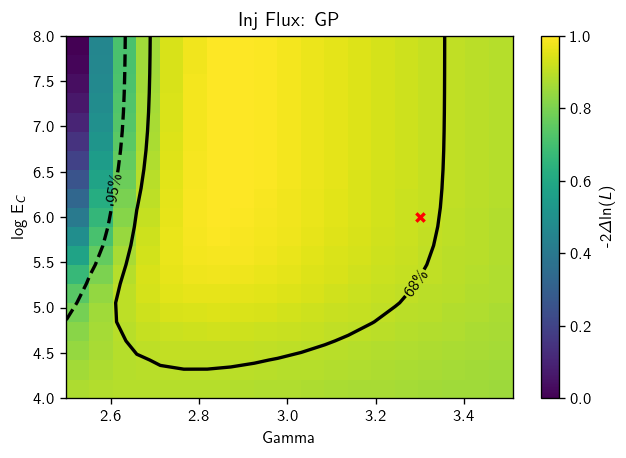

In [205]:
fig, ax = plt.subplots()
gamma, cutoff = np.meshgrid( fit_gammas, np.log10(fit_cutoffs),)
delta_t = -(trials - np.max(trials))
plt.pcolormesh(gamma, cutoff, delta_t.T,
           cmap='viridis_r')

gamma, cutoff = np.meshgrid( fit_gammas, np.log10(fit_cutoffs),)
contour_fracs = [0.68, .95]
dLLHs = stats.chi2.ppf (contour_fracs, 3)
contour_labels = {dLLH: r'{:.0f}$\%$'.format (100*frac) for (dLLH, frac) in zip (dLLHs, contour_fracs)}


plt.scatter(inj_gamma, np.log10(inj_cutoff), marker='x', s=25, c='r', label='inj')
plt.colorbar(label='-2$\Delta$ln($L$)')

cont = plt.contour(fit_gammas, np.log10(fit_cutoffs), delta_t.T, dLLHs, colors='k', linestyles=['solid', 'dashed'])
ax.clabel (cont, inline=True, fmt=contour_labels, fontsize=10, inline_spacing=1)
plt.xlabel('Gamma')
plt.ylabel('log E$_{C}$ ')
plt.title('Inj Flux: GP')

In [206]:
fit_fluxes = np.linspace(1,10,40) * 1e-10
fit_gammas = np.linspace(2.5,3.5,40)

In [207]:
trials = np.ndarray((len(fit_gammas), len(fit_fluxes)))
injs = np.ndarray((len(fit_gammas), len(fit_fluxes)))
def get_trials_from_cutoff (c):
    for i, g in enumerate(fit_gammas):
        for j, f in enumerate(fit_fluxes):
            print(g, c)
            tr = get_tr(temp, g, c)
            L = tr.get_one_llh_from_trial(trial)
            ns=tr.to_ns(f, E0=1, unit=1e3,
                             flux=cy.hyp.PowerLawFlux(g, energy_cutoff=c))
            delta_2llh = -2*L.get_minus_llh_ratio(ns=ns)
            print(ns)
            trials[i][j] = delta_2llh
    return trials

In [208]:
trials = get_trials_from_cutoff(1e8)

2.5 100000000.0
Reading /data/ana/analyses/NuSources/2021_DNNCascade_analyses/templates/Fermi-LAT_pi0_map.npy ...
<- /data/user/ssclafani/csky_fit/template_caches/DNNCascade_10yr.template.npy    
Restore successful.
172.64450541161474
2.5 100000000.0
Reading /data/ana/analyses/NuSources/2021_DNNCascade_analyses/templates/Fermi-LAT_pi0_map.npy ...
<- /data/user/ssclafani/csky_fit/template_caches/DNNCascade_10yr.template.npy    
Restore successful.
212.48554512198737
2.5 100000000.0
Reading /data/ana/analyses/NuSources/2021_DNNCascade_analyses/templates/Fermi-LAT_pi0_map.npy ...
<- /data/user/ssclafani/csky_fit/template_caches/DNNCascade_10yr.template.npy    
Restore successful.
252.32658483236003
2.5 100000000.0
Reading /data/ana/analyses/NuSources/2021_DNNCascade_analyses/templates/Fermi-LAT_pi0_map.npy ...
<- /data/user/ssclafani/csky_fit/template_caches/DNNCascade_10yr.template.npy    
Restore successful.
292.16762454273265
2.5 100000000.0
Reading /data/ana/analyses/NuSources/2021_DN

/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """


Text(0.5, 1.0, 'Inj Flux: GP')

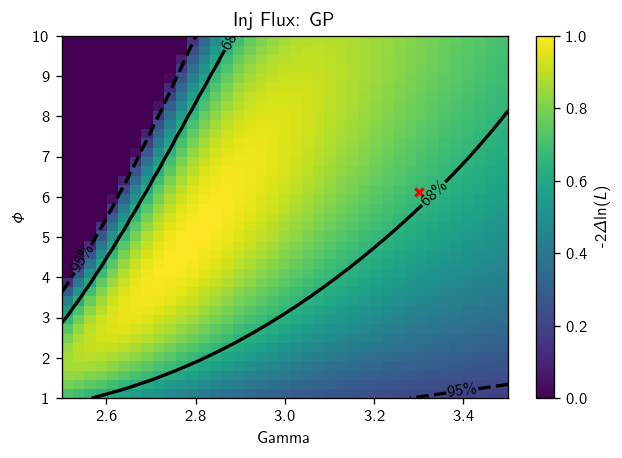

In [209]:
fig, ax = plt.subplots()
gamma, dNdE = np.meshgrid( fit_gammas, fit_fluxes*1e10,)
delta_t = -(trials - np.max(trials))
plt.pcolormesh(gamma, dNdE, delta_t.T,
           cmap='viridis_r',vmax=10)

contour_fracs = [0.68, .95]
dLLHs = stats.chi2.ppf (contour_fracs, 3)
contour_labels = {dLLH: r'{:.0f}$\%$'.format (100*frac) for (dLLH, frac) in zip (dLLHs, contour_fracs)}


plt.scatter(inj_gamma, f1*1e10, marker='x', s=25, c='r', label='inj')
plt.colorbar(label='-2$\Delta$ln($L$)')

cont = plt.contour(fit_gammas, fit_fluxes*1e10, delta_t.T, dLLHs, colors='k', linestyles=['solid', 'dashed'])
ax.clabel (cont, inline=True, fmt=contour_labels, fontsize=10, inline_spacing=1)
plt.xlabel('Gamma')
plt.ylabel('$\Phi$')
plt.title('Inj Flux: GP')

In [228]:

def get_trials_from_gamma(g):
    trials = np.ndarray((len(fit_cutoffs), len(fit_fluxes)))
    injs = np.ndarray((len(fit_cutoffs), len(fit_fluxes)))
    for i, c in enumerate(fit_cutoffs):
        for j, f in enumerate(fit_fluxes):
            print(c, f)
            tr = get_tr(temp, g, c)
            L = tr.get_one_llh_from_trial(trial)
            ns=tr.to_ns(f, E0=1, unit=1e3,
                             flux=cy.hyp.PowerLawFlux(g, energy_cutoff=c))
            delta_2llh = -2*L.get_minus_llh_ratio(ns=ns)
            print(ns)
            trials[i][j] = delta_2llh
    return trials

In [229]:
fit_fluxes = np.linspace(1,10,20) * 1e-10
fit_cutoffs = np.logspace(4,8,20) #GeV

In [230]:
trials.shape

(20, 40)

In [231]:
trials = get_trials_from_gamma(3.0)

10000.0 1e-10
Reading /data/ana/analyses/NuSources/2021_DNNCascade_analyses/templates/Fermi-LAT_pi0_map.npy ...
<- /data/user/ssclafani/csky_fit/template_caches/DNNCascade_10yr.template.npy    
Restore successful.
64.52138247514527
10000.0 1.4736842105263158e-10
Reading /data/ana/analyses/NuSources/2021_DNNCascade_analyses/templates/Fermi-LAT_pi0_map.npy ...
<- /data/user/ssclafani/csky_fit/template_caches/DNNCascade_10yr.template.npy    
Restore successful.
95.08414259495095
10000.0 1.9473684210526314e-10
Reading /data/ana/analyses/NuSources/2021_DNNCascade_analyses/templates/Fermi-LAT_pi0_map.npy ...
<- /data/user/ssclafani/csky_fit/template_caches/DNNCascade_10yr.template.npy    
Restore successful.
125.64690271475659
10000.0 2.4210526315789473e-10
Reading /data/ana/analyses/NuSources/2021_DNNCascade_analyses/templates/Fermi-LAT_pi0_map.npy ...
<- /data/user/ssclafani/csky_fit/template_caches/DNNCascade_10yr.template.npy    
Restore successful.
156.20966283456224
10000.0 2.894736842

In [232]:
trials.shape

(20, 20)

/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """


Text(0.5, 1.0, 'Inj Flux: GP')

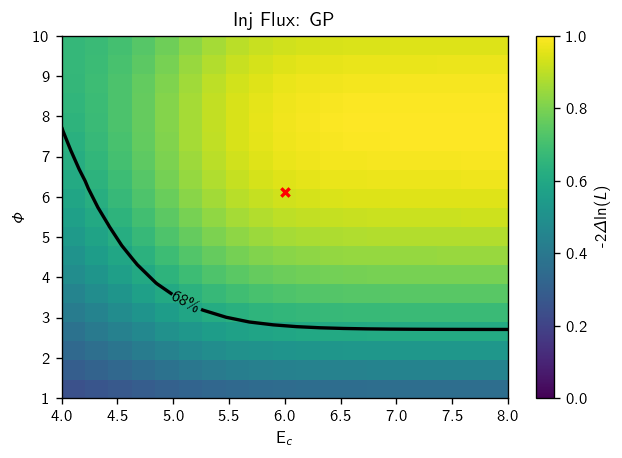

In [236]:
fig, ax = plt.subplots()
cs, dNdE = np.meshgrid( np.log10(fit_cutoffs), fit_fluxes*1e10,)
delta_t = -(trials - np.max(trials))
plt.pcolormesh(cs, dNdE, delta_t.T,
           cmap='viridis_r',vmax=10)

contour_fracs = [0.68, .95]
dLLHs = stats.chi2.ppf (contour_fracs, 3)
contour_labels = {dLLH: r'{:.0f}$\%$'.format (100*frac) for (dLLH, frac) in zip (dLLHs, contour_fracs)}


plt.scatter(np.log10(inj_cutoff), f1*1e10, marker='x', s=25, c='r', label='inj')
plt.colorbar(label='-2$\Delta$ln($L$)')

cont = plt.contour(np.log10(fit_cutoffs), fit_fluxes*1e10, delta_t.T, dLLHs, colors='k', linestyles=['solid', 'dashed'])
ax.clabel (cont, inline=True, fmt=contour_labels, fontsize=10, inline_spacing=1)
plt.xlabel('E$_{c}$')
plt.ylabel('$\Phi$')
plt.title('Inj Flux: GP')

In [33]:
dNdE = np.linspace (0, 10e-18,1000)
gammas = np.r_[1.0:3.5001:2**-4]

get_ns_from_flux = lambda dNdE,  **params: cy.hyp.PowerLawFlux(params['gamma']).to_ns (dNdE, L.get_acc_total (**params), 
                                                                                       E0=1e5, unit=1, use_E2dNdE=False)
    
mesh_tss, (mesh_fluxs, mesh_gammas) = L.scan_ts (dNdE, gamma=gammas, get_ns_from_arg=get_ns_from_flux)


          gamma
     3.5000e+00
Done.


2.6875 2.7427427427427427e-18
[3.52674038 7.8147279 ]


/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


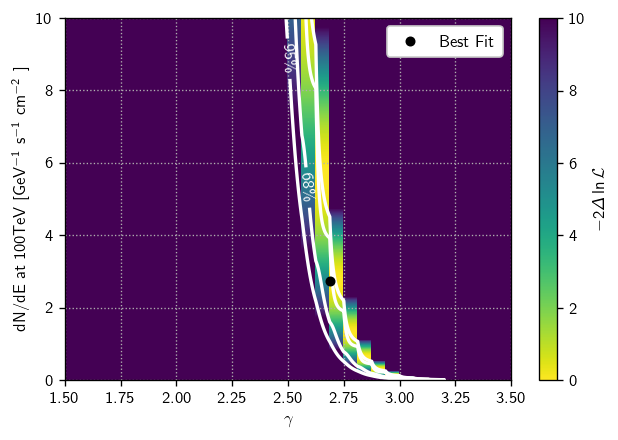

In [37]:
Z = np.max(mesh_tss) - mesh_tss

x, y =np.unravel_index(np.argmin(Z), Z.shape)
#print(stats.norm.isf(np.mean(bkg_dict['pi0'] > np.max(mesh_tss))))
flux_best = dNdE[x]
gamma_best = gammas[y]
print(gamma_best, flux_best)

fig, ax = plt.subplots ()
pc = ax.pcolormesh (gammas, 1e18*dNdE , Z, cmap='viridis_r', vmin=0, vmax = 10.01)
contour_fracs = [1 - 2*stats.norm.sf(1), 0.95]
dLLHs = stats.chi2.ppf (contour_fracs, 3)
print(dLLHs)
contour_labels = {dLLH: r'{:.0f}$\%$'.format (100*frac) for (dLLH, frac) in zip (dLLHs, contour_fracs)}
cont = ax.contour (gammas, 1e18*dNdE, Z, dLLHs, colors='w')
ax.clabel (cont, inline=True, fmt=contour_labels)
#ax.plot (gamma_true, flux_true, '.', ms=10, color='r', label='Analysis')
cb = fig.colorbar (pc)
cb.set_label (r'$-2\Delta\ln\mathcal{L}$')
ax.plot (gamma_best,1e18* flux_best, '.', ms=10, color='k', label='Best Fit')

#cb.set_ticks (np.r_[0:10000.1:100])
ax.set_xlabel (r'$\gamma$')
ax.set_ylabel (r'dN/dE at 100TeV [GeV$^{-1}$  s$^{-1}$ cm$^{-2}$ ] ')
ax.set_xlim (1.5, 3.5)
#ax.set_ylim (0, .3e-11)
plt.legend()
ax.grid();

In [21]:
dNdE_log = np.logspace (-19, -17, 2000)
gammas_log = np.r_[1.0:3.5001:2**-5]

get_ns_from_flux = lambda E2dNdE,  **params: cy.hyp.PowerLawFlux(params['gamma']).to_ns (dNdE_log, L.get_acc_total (**params),
                                                                                         E0=1e5, unit=1, use_E2dNdE=False)
    
mesh_tss_log, (mesh_fluxs_log, mesh_gammas_log) = L.scan_ts (dNdE_log, gamma=gammas_log, get_ns_from_arg=get_ns_from_flux)


          gamma
     1.0000e+00

TypeError: to_ns() got an unexpected keyword argument 'E2dNdE'

In [ ]:
f1 =  inj_tr.to_E2dNdE(750, E0=1, unit=1e3, flux=cy.hyp.PowerLawFlux(2.7, energy_cutoff=np.inf))
print(f1)
print('Flux of GP at 1 TeV')

In [ ]:
inj_gamma = 3.0
inj_cutoff =1e6#GeV 10 PeV
inj_conf = get_conf(inj_gamma, inj_cutoff)


In [12]:
fit_gammas = np.arange(2.5,3.51,.1)
fit_cutoffs = np.logspace(4,8,12) #GeV